# Answering Business Questions using SQL

In this project, we are working with a database from Chinook containing information about a fictional digital music shop. We will perform SQLite queries in order to answer a number of business questions:
* Which genre should be invested for the USA customers?
* Which support representative totalizes the most sales from customers?
* Which countries make the most sales / have the most customers?
* Should the company shift focus towards single track purchases instead of complete album purchases?

In [184]:
# import basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

# create utility functions
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_tables():
    q = """
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view')
    """
    return run_query(q)

# show available tables
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Choosing new artists based on genre
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name| 	Genre|
|---|---|
|Regal 	|Hip-Hop|
|Red Tone 	|Punk|
|Meteor and the Girls 	|Pop|
|Slim Jim Bites 	|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA. 

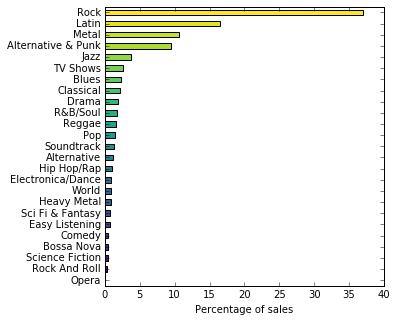

In [219]:
query = """
    WITH 
        track_genre AS
        (
            SELECT
                t.*,
                g.name genre
            FROM track t
            LEFT JOIN genre g ON t.genre_id=g.genre_id 
        )
        
    SELECT 
        genre,
        COUNT(*) genre_count,
        CAST(COUNT(*) as float)/(SELECT COUNT(*) FROM track_genre) * 100 genre_percent
    from track_genre
    GROUP BY genre
    ORDER BY genre_percent
"""
df = run_query(query)
df.set_index('genre')

c = plt.get_cmap('viridis')(np.linspace(0,1,df.shape[0]))

ax = df.plot(kind='barh', x='genre', y='genre_percent', figsize=(5,5), color=c)
ax.get_legend().remove()
ax.set_xlabel('Percentage of sales')
ax.set_ylabel('')
plt.show()

Based on the best selling genres, the disc label should choose the following three artists:
* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)



### Analyze purchases of customers by support agent
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

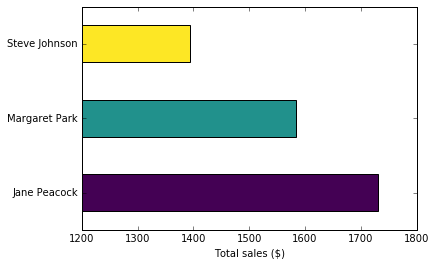

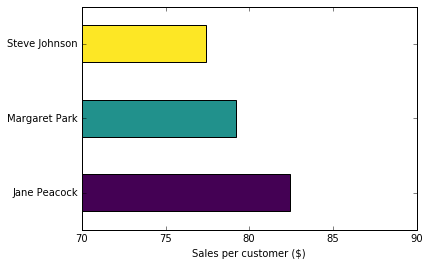

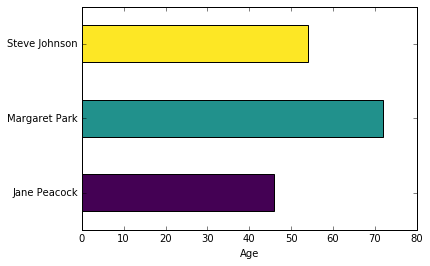

In [207]:
query = """
    SELECT 
        (e.first_name || " " || e.last_name) name, 
        e.hire_date,
        e.birthdate,
        SUM(i.total) total_sales,
        COUNT(DISTINCT(c.customer_id)) number_customers
    FROM employee e
    LEFT JOIN customer c ON e.employee_id=c.support_rep_id 
    LEFT JOIN invoice i ON c.customer_id=i.customer_ID
    WHERE e.title="Sales Support Agent"
    GROUP BY employee_id
"""
df = run_query(query)
df['sales_per_customer'] = df['total_sales'] / df['number_customers']
df['age'] = 2019 - df['birthdate'].str.extract('([\d]+)-[\d]+-[\d]+', expand=False).astype(int)
df['year_employment'] = 2019 - df['hire_date'].str.extract('([\d]+)-[\d]+-[\d]+', expand=False).astype(int)


c = plt.get_cmap('viridis')(np.linspace(0,1,df.shape[0]))

ax = df.plot(kind='barh', x='name', y='total_sales', xlim=(1200,1800), color=c)
ax.set_ylabel('')
ax.set_xlabel('Total sales ($)')
ax.get_legend().remove()
ax = df.plot(kind='barh', x='name', y='sales_per_customer', xlim=(70,90), color=c)
ax.set_ylabel('')
ax.set_xlabel('Sales per customer ($)')
ax.get_legend().remove()
ax = df.plot(kind='barh', x='name', y='age', color=c)
ax.set_xlabel('Age')
ax.set_ylabel('')
ax.get_legend().remove()
plt.show()

Jane Peacock is support agent with best sales, even when divided by number of customers. She is also the youngest, which means that maybe she connects more with clients which are probably younger (however with three samples there are no conclusions to be drawn).

### Analyzing statistics by country
Now we will agregate data, for each country, on:
*    total number of customers
*   total value of sales
*   average value of sales per customer
*   average order value


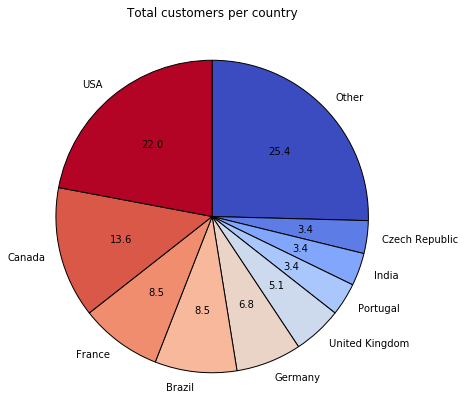

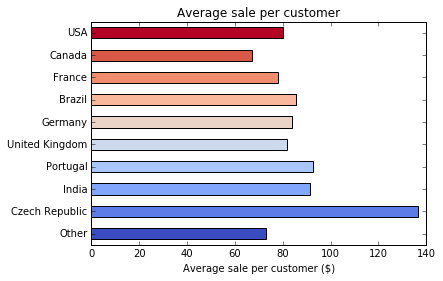

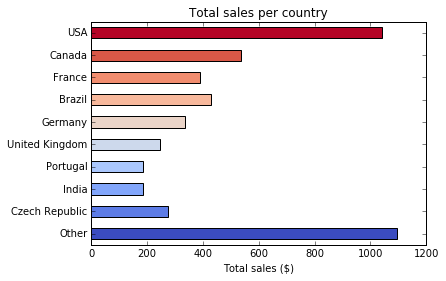

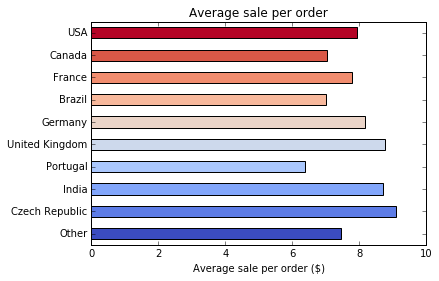

In [210]:
q = """
    WITH 
    -- aggregate and mark countries with single customer as 'Other'
    first_groupby AS
    (
        SELECT 
            CASE
                WHEN COUNT(DISTINCT(c.customer_id))=1 THEN 'Other'
                ELSE c.country
            END country ,
            COUNT(DISTINCT(c.customer_id)) total_customers,
            SUM(i.total) total_sales,
            COUNT(i.total) total_invoices,
            CASE
                WHEN COUNT(DISTINCT(c.customer_id))=1 THEN 1
                ELSE 0
            END other_flag
        FROM customer c
        LEFT JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY country
    ),
    -- aggregate the countries from the 'Other' category
    second_groupby AS 
    (
        SELECT 
            country,
            SUM(total_customers) total_customers,
            SUM(total_sales) total_sales,
            SUM(total_invoices) total_invoices,
            other_flag
        FROM first_groupby
        GROUP BY country
    )
    
    -- main query 
    SELECT 
        country,
        total_customers total_customers,
        total_sales total_sales,
        total_sales/total_customers avg_sale_per_customer,
        total_sales/total_invoices avg_sale_per_order
    FROM second_groupby
    ORDER BY other_flag DESC, total_customers 
"""
df = run_query(q)
df = df.set_index('country')

c = plt.get_cmap('coolwarm')(np.linspace(0,1,df.shape[0]))


ax = df.plot(kind='pie', y='total_customers', startangle=90, counterclock=False,
             figsize=(7,7), colors=c, autopct='%.1f')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Total customers per country')
ax.get_legend().remove()
ax = df.plot(kind='barh', y='avg_sale_per_customer', color=c)
ax.set_ylabel('')
ax.set_xlabel('Average sale per customer ($)')
ax.set_title('Average sale per customer')
ax.get_legend().remove()
ax = df.plot(kind='barh', y='total_sales', color=c)
ax.set_ylabel('')
ax.set_xlabel('Total sales ($)')
ax.set_title('Total sales per country')
ax.get_legend().remove()
ax = df.plot(kind='barh', y='avg_sale_per_order', color=c)
ax.set_ylabel('')
ax.set_xlabel('Average sale per order ($)')
ax.set_title('Average sale per order')
ax.get_legend().remove()
plt.show()

The biggest customers are USA and Canada, followed by France, Brazil and Germany. Brazil makes more sales than France despite having fewer customers, it is an interesting market to target. In terms of sales per customer, Czech Repulic is by far the highest, thus it could be profitable to market this area further.

# Should the purchasing strategy shift to single tracks instead of whole albums?
Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. In the next step, we will find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [276]:
q = """
WITH 
invoice_info AS
(
    SELECT 
        i.invoice_id,
        t.track_id,
        t.album_id
    FROM invoice i
    LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id 
    LEFT JOIN track t ON t.track_id = il.track_id 
),
albums_and_tracks AS
(
    SELECT
        t.track_id,
        t.album_id
    FROM album al
    LEFT JOIN track t ON t.album_id = al.album_id
),
is_invoice_album AS
(
    SELECT 
        invoice_id,
        CASE
            WHEN (
                (SELECT track_id FROM albums_and_tracks WHERE album_id=ii.album_id
                 EXCEPT
                 SELECT track_id FROM invoice_info WHERE invoice_id=ii.invoice_id
                ) IS NULL
            AND
                (SELECT track_id FROM invoice_info WHERE invoice_id=ii.invoice_id
                 EXCEPT
                 SELECT track_id FROM albums_and_tracks WHERE album_id=ii.album_id
                ) IS NULL
            ) THEN 1
            ELSE 0
        END is_album
    FROM invoice_info ii
    GROUP BY ii.invoice_id
)

SELECT 
    CASE
        WHEN is_album=0 THEN 'False'
        WHEN is_album=1 THEN 'True'
    END is_album,
    COUNT(is_album) number_of_invoices,
    CAST(COUNT(is_album) as float)/(SELECT COUNT(*) FROM is_invoice_album)*100 percentage_of_invoices
FROM is_invoice_album
GROUP BY is_album
"""

run_query(q)

,is_album,number_of_invoices,percentage_of_invoices
0,False,500,81.433225
1,True,114,18.566775


19% of invoices are complete albums. While not a majority, this is a significant part of purchases. To be considered is also the fact that even clients making non-album purchases might move away from the platform if not all songs are available for purchase. To better assess the situation, it would be recommandable to perform a survey among customers.

# Conclusion

In this project, we perform SQLite queries on a fictional database containing information about a  digital music shop. We could rank the most popular genres from USA purchases and make a business decision based on the results. The three Sales Support agents were compared in terms of performance - we learned than Jane Peacock is deals with the most sales. The biggest customers are USA and Canada, while Brazil and Czech Repulic were also outlined as potential candidates for market growth. We deemed feasible the possibility of buying uniquely single tracks instead of complete albums, buy raised a warning concerning a possible dissatisfaction from the customer base and recommended to conduct a survey for further investigation of outcomes. 